##### IMPORTACION DEL DATASET

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import RFE

In [32]:
df = pd.read_csv("D:\\Descargas\\archive (1)\\superstore_data.csv")
df.head()

,Id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain
0,1826,1970,Graduation,Divorced,84835.0,0,0,6/16/2014,0,189,...,111,189,218,1,4,4,6,1,1,0
1,1,1961,Graduation,Single,57091.0,0,0,6/15/2014,0,464,...,7,0,37,1,7,3,7,5,1,0
2,10476,1958,Graduation,Married,67267.0,0,1,5/13/2014,0,134,...,15,2,30,1,3,2,5,2,0,0
3,1386,1967,Graduation,Together,32474.0,1,1,11/5/2014,0,10,...,0,0,0,1,1,0,2,7,0,0
4,5371,1989,Graduation,Single,21474.0,1,0,8/4/2014,0,6,...,11,0,34,2,3,1,2,7,1,0


In [33]:
df.shape

(2240, 22)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [35]:
df.isnull().sum()

Id                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
Response                0
Complain                0
dtype: int64

In [36]:
df.Income = df.Income.fillna(df.Income.mean())

In [37]:
df.duplicated().sum()

0

In [38]:
df["Age"] = 2022 - df["Year_Birth"]

In [39]:
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"])

l_years = []
for i in df["Dt_Customer"]:
  f = dt.datetime.now().date() - i.date()
  l_years.append(f.days/365)
df.insert(loc=23, column="Year_Dt", value = l_years)

In [40]:
df = df.drop(["Id", "Year_Birth", "Dt_Customer"], axis=1)

##### TRANSFORMACIÓN DE LAS VARIABLES DUMMY

In [41]:
df_c_dummy = df.columns[df.dtypes == object]
df_dummy = pd.get_dummies(data= df, prefix = df_c_dummy, drop_first = True)

In [42]:
# Para acelerar los procesos computacionales convertimos todos los elementos al tipo de archivo float
df_dummy = df_dummy.astype(float)
df_dummy.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO
0,84835.0,0.0,0.0,0.0,189.0,104.0,379.0,111.0,189.0,218.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,57091.0,0.0,0.0,0.0,464.0,5.0,64.0,7.0,0.0,37.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,67267.0,0.0,1.0,0.0,134.0,11.0,59.0,15.0,2.0,30.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,32474.0,1.0,1.0,0.0,10.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,21474.0,1.0,0.0,0.0,6.0,16.0,24.0,11.0,0.0,34.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


##### ESCALADO DE LAS VARIABLES

In [43]:
X = df_dummy.drop("Response", axis=1)
y = df["Response"].values.reshape(-1,1)

In [44]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X = pd.DataFrame(scaler_X.fit_transform(X), columns=X.columns)
y = scaler_y.fit_transform(y) 

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

##### BALANCEO DE LAS CLASES

Si una clase es dominante en cantidad respecto al otro, puede ocacionar cesgo, para evitar eso balanceamos los datos.

In [46]:
df_dummy.Response.value_counts()

0.0    1906
1.0     334
Name: Response, dtype: int64

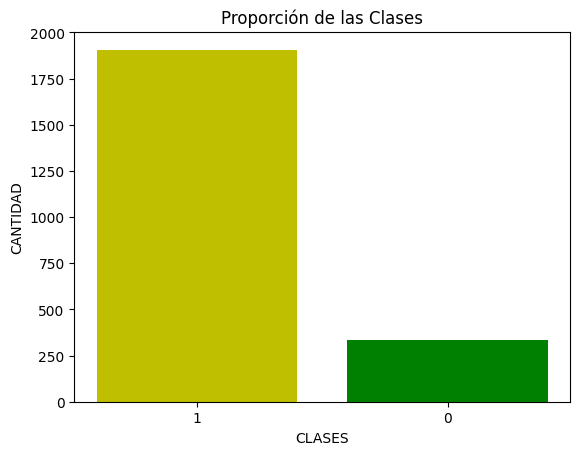

In [47]:
plt.bar(x=df.Response.astype(str).unique(), height = df.Response.value_counts(), color = ["y", "g"]);
plt.title("Proporción de las Clases")
plt.xlabel("CLASES")
plt.ylabel("CANTIDAD")
plt.show()

In [48]:
smote = SMOTETomek(random_state=0)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

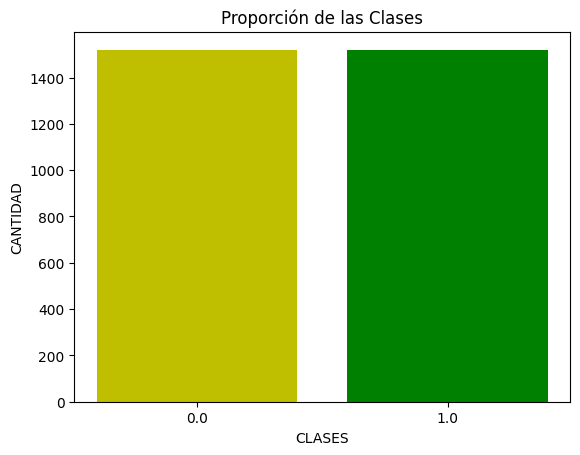

In [51]:
y_df = pd.DataFrame(y_train_sm)

plt.bar(x=y_df[0].astype(str).unique(), height = y_df.value_counts(), color = ["y", "g"]);
plt.title("Proporción de las Clases")
plt.xlabel("CLASES")
plt.ylabel("CANTIDAD")
plt.show()

##### RANDOM FOREST

In [70]:
model = RandomForestClassifier(n_jobs=-1)

# Define el rango de valores para los parámetros a ser optimizados
param_dist = {
    "n_estimators": np.arange(50, 601, 50),
    "max_depth": np.arange(10,31,5),
    "min_samples_split": np.arange(2, 20, 2),
    "min_samples_leaf": np.arange(1, 20, 2)
}

random_search = RandomizedSearchCV(
    model, param_distributions=param_dist, n_iter=10, cv=10, n_jobs=-1
)

random_search.fit(X_train_sm, y_train_sm)

best_parameters:  {'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 30}


In [71]:
best_parameters = random_search.best_params_
print("best_parameters: ", best_parameters)
best_accuracy = random_search.best_score_
print("best_accuracy: ", best_accuracy)

best_parameters:  {'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 30}
best_accuracy:  0.9404605263157896


##### PREDICCIÓN

In [72]:
rf = RandomForestClassifier(n_estimators=100, min_samples_split= 4, min_samples_leaf= 1, max_depth=30, random_state=0).fit(X_train_sm, y_train_sm)
y_train_pred = rf.predict(X_train_sm)
y_test_pred = rf.predict(X_test)

In [73]:
print("Accuracy: {:.2f} %".format(accuracy_score(y_test, y_test_pred)*100))

Accuracy: 88.62 %


In [74]:
accuracies = cross_val_score(estimator = rf, X = X_train_sm, y = y_train_sm, cv = 10)
print("Validación Cruzada: {:.2f} %".format(accuracies.mean()*100))

Validación Cruzada: 93.49 %


In [75]:
print("Metrics:\n {}".format(classification_report(y_test, y_test_pred)))

Metrics:
               precision    recall  f1-score   support

         0.0       0.93      0.94      0.93       384
         1.0       0.61      0.56      0.59        64

    accuracy                           0.89       448
   macro avg       0.77      0.75      0.76       448
weighted avg       0.88      0.89      0.88       448



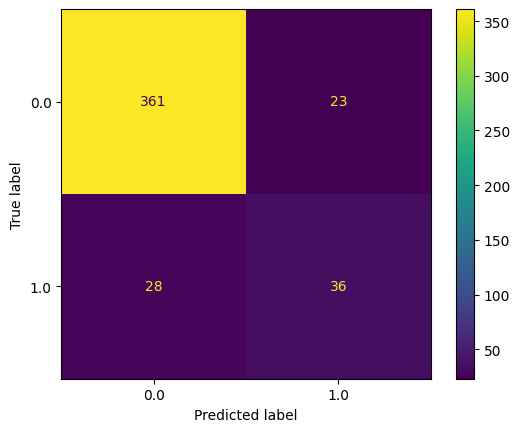

In [76]:
# MATRIZ DE CONFUSION
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)

##### CURVA ROC

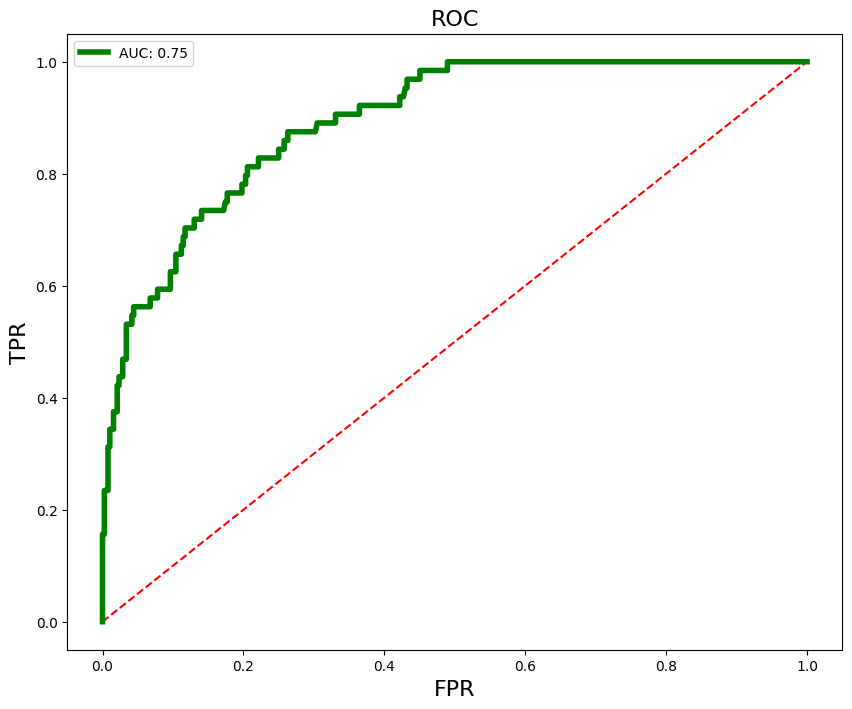

In [77]:
plt.figure(figsize = (10,8))
plt.plot([0,1],[0,1], "r--")

probs = rf.predict_proba(X_test)

probs = probs[:, 1]
fpr,tpr, thresholds = roc_curve(y_test, probs) 
roc_auc = roc_auc_score(y_test, y_test_pred)

label = "AUC: " + "{:.2F}".format(roc_auc)
plt.plot(fpr, tpr, c = "g", label=label, linewidth=4)
plt.xlabel("FPR", fontsize=16)
plt.ylabel("TPR", fontsize=16)
plt.title("ROC", fontsize=16)
plt.legend();

##### AUN PODEMOS MEJORAR UN POCO EL MODELO

SELECCION DE VARIABLES

Seleccionamos las variables mas significativas para el modelo.

In [192]:
from sklearn.linear_model import LogisticRegression
estimator = LogisticRegression()
selector = RFE(estimator=estimator, n_features_to_select = 22, step=1)
selector.fit(X_train_sm, y_train_sm.ravel())

print(selector.support_)
print(selector.ranking_)
best_variables = selector.support_

[False  True  True  True  True False  True  True False  True  True  True
  True  True  True  True False  True  True  True  True  True  True False
  True False  True  True False]
[2 1 1 1 1 4 1 1 6 1 1 1 1 1 1 1 7 1 1 1 1 1 1 8 1 5 1 1 3]


In [128]:
model = RandomForestClassifier(n_jobs=-1)

param_dist = {
    "n_estimators": np.arange(50, 601, 50),
    "max_depth": np.arange(10,31,5),
    "min_samples_split": np.arange(2, 20, 2),
    "min_samples_leaf": np.arange(1, 20, 2)
}

random_search = RandomizedSearchCV(
    model, param_distributions=param_dist, n_iter=10, cv=10, n_jobs=-1
)

random_search.fit(X_train_sm.iloc[:, best_variables], y_train_sm.ravel());

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(n_jobs=-1),
                   n_jobs=-1,
                   param_distributions={'max_depth': array([10, 15, 20, 25, 30]),
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600])})

In [129]:
best_parameters = random_search.best_params_
print("best_parameters: ", best_parameters)
best_accuracy = random_search.best_score_
print("best_accuracy: ", best_accuracy)

best_parameters:  {'n_estimators': 100, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_depth': 25}
best_accuracy:  0.9194078947368421


##### PREDICCION

In [193]:
rf = RandomForestClassifier(n_estimators=100, min_samples_split= 12, min_samples_leaf= 1, max_depth=25, random_state=0).fit(X_train_sm.iloc[:, best_variables], y_train_sm)
y_train_pred = rf.predict(X_train_sm.iloc[:, best_variables])
y_test_pred = rf.predict(X_test.iloc[:, best_variables])

##### METRICAS

In [194]:
print("Accuracy: {:.2f} %".format(accuracy_score(y_test, y_test_pred)*100))

Accuracy: 90.18 %


In [195]:
accuracies = cross_val_score(estimator = rf, X = X_train_sm.iloc[:, best_variables], y = y_train_sm, cv = 10, n_jobs=-1)
print("Validación Cruzada: {:.2f} %".format(accuracies.mean()*100))

Validación Cruzada: 92.07 %


In [196]:
print("Metrics:\n {}".format(classification_report(y_test, y_test_pred)))

Metrics:
               precision    recall  f1-score   support

         0.0       0.94      0.94      0.94       384
         1.0       0.66      0.66      0.66        64

    accuracy                           0.90       448
   macro avg       0.80      0.80      0.80       448
weighted avg       0.90      0.90      0.90       448



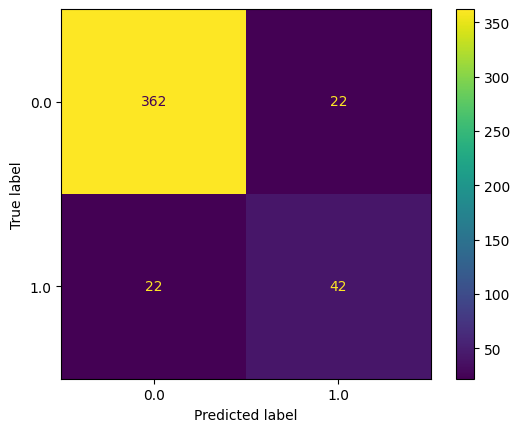

In [197]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred);

##### CURVA ROC

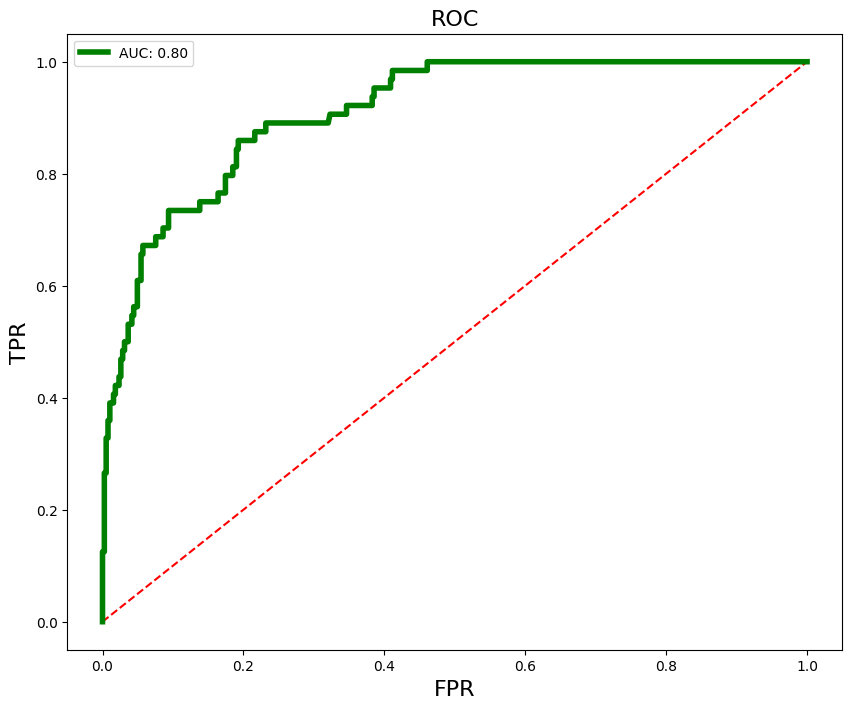

In [198]:
plt.figure(figsize = (10,8))
plt.plot([0,1],[0,1], "r--")

probs = rf.predict_proba(X_test.iloc[:, best_variables])

probs = probs[:, 1]
fpr,tpr, thresholds = roc_curve(y_test, probs) 
roc_auc = roc_auc_score(y_test, y_test_pred)

label = "AUC: " + "{:.2F}".format(roc_auc)
plt.plot(fpr, tpr, c = "g", label=label, linewidth=4)
plt.xlabel("FPR", fontsize=16)
plt.ylabel("TPR", fontsize=16)
plt.title("ROC", fontsize=16)
plt.legend();